# ELAIS-S1 Selection Functions
## Depth maps and selection functions

The simplest selection function available is the field MOC which specifies the area for which there is Herschel data. Each pristine catalogue also has a MOC defining the area for which that data is available.

The next stage is to provide mean flux standard deviations which act as a proxy for the catalogue's 5$\sigma$ depth

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-27 20:54:48.861561


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

In [3]:
FIELD = 'ELAIS-S1'
#FILTERS_DIR = "/Users/rs548/GitHub/herschelhelp_python/database_builder/filters/"
FILTERS_DIR = "/opt/herschelhelp_python/database_builder/filters/"

In [4]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_{}_{}.fits".format(FIELD.lower(), SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Depth maps produced using: {}".format(master_catalogue_filename))

ORDER = 10
#TODO write code to decide on appropriate order

field_moc = MOC(filename="../../dmu2/dmu2_field_coverages/{}_MOC.fits".format(FIELD))

Depth maps produced using: master_catalogue_elais-s1_20180221.fits


In [ ]:
# Remove sources whose signal to noise ratio is less than five as these will have been selected using forced 
# photometry and so the errors will not refelct the RMS of the map 
for n,col in enumerate(master_catalogue.colnames):
    if col.startswith("f_"):
        err_col = "ferr{}".format(col[1:])
        errs = master_catalogue[err_col]
        fluxes = master_catalogue[col]
        mask = fluxes/errs < 5.0
        master_catalogue[col][mask] = np.nan
        master_catalogue[err_col][mask] = np.nan

## I - Group masterlist objects by healpix cell and calculate depths
We add a column to the masterlist catalogue for the target order healpix cell <i>per object</i>.

In [5]:
#Add a column to the catalogue with the order=ORDER hp_idx
master_catalogue.add_column(Column(data=coords_to_hpidx(master_catalogue['ra'],
                                                       master_catalogue['dec'],
                                                       ORDER), 
                                   name="hp_idx_O_{}".format(str(ORDER))
                                  )
                           )

In [6]:
# Convert catalogue to pandas and group by the order=ORDER pixel

group = master_catalogue.group_by(["hp_idx_O_{}".format(str(ORDER))])

In [7]:
#Downgrade the groups from order=ORDER to order=13 and then fill out the appropriate cells
#hp.pixelfunc.ud_grade([2599293, 2599294], nside_out=hp.order2nside(13))

## II Create a table of all Order=13 healpix cells in the field and populate it
We create a table with every order=13 healpix cell in the field MOC. We then calculate the healpix cell at lower order that the order=13 cell is in. We then fill in the depth at every order=13 cell as calculated for the lower order cell that that the order=13 cell is inside.

In [8]:
depths = Table()
depths['hp_idx_O_13'] = list(field_moc.flattened(13))

In [9]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13
0,579756256
1,579803943
2,579756257
3,579756258
4,579756259
5,579756260
6,579756261
7,579756262
8,579756263
9,579756264


In [10]:
depths.add_column(Column(data=hp.pixelfunc.ang2pix(2**ORDER,
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[0],
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[1],
                     nest = True),
                     name="hp_idx_O_{}".format(str(ORDER))
                        )
                 )

In [11]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10
0,579756256,9058691
1,579803943,9059436
2,579756257,9058691
3,579756258,9058691
4,579756259,9058691
5,579756260,9058691
6,579756261,9058691
7,579756262,9058691
8,579756263,9058691
9,579756264,9058691


In [12]:
for col in master_catalogue.colnames:
    if col.startswith("f_"):
        errcol = "ferr{}".format(col[1:])
        depths = join(depths, 
                      group["hp_idx_O_{}".format(str(ORDER)), errcol].groups.aggregate(np.nanmean),
                     join_type='left')
        depths[errcol].name = errcol + "_mean"
        depths = join(depths, 
                      group["hp_idx_O_{}".format(str(ORDER)), col].groups.aggregate(lambda x: np.nanpercentile(x, 90.)),
                     join_type='left')
        depths[col].name = col + "_p90"

depths[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10,ferr_ap_wfi_b_mean,f_ap_wfi_b_p90,ferr_wfi_b_mean,f_wfi_b_p90,ferr_ap_wfi_b123_mean,f_ap_wfi_b123_p90,ferr_wfi_b123_mean,f_wfi_b123_p90,ferr_ap_wfi_v_mean,f_ap_wfi_v_p90,ferr_wfi_v_mean,f_wfi_v_p90,ferr_ap_wfi_r_mean,f_ap_wfi_r_p90,ferr_wfi_r_mean,f_wfi_r_p90,ferr_ap_irac_i3_mean,f_ap_irac_i3_p90,ferr_irac_i3_mean,f_irac_i3_p90,ferr_ap_irac_i4_mean,f_ap_irac_i4_p90,ferr_irac_i4_mean,f_irac_i4_p90,ferr_ap_decam_g_mean,f_ap_decam_g_p90,ferr_decam_g_mean,f_decam_g_p90,ferr_ap_decam_r_mean,f_ap_decam_r_p90,ferr_decam_r_mean,f_decam_r_p90,ferr_ap_decam_i_mean,f_ap_decam_i_p90,ferr_decam_i_mean,f_decam_i_p90,ferr_ap_decam_z_mean,f_ap_decam_z_p90,ferr_decam_z_mean,f_decam_z_p90,ferr_ap_decam_y_mean,f_ap_decam_y_p90,ferr_decam_y_mean,f_decam_y_p90,ferr_ap_irac_i1_mean,f_ap_irac_i1_p90,ferr_irac_i1_mean,f_irac_i1_p90,ferr_ap_irac_i2_mean,f_ap_irac_i2_p90,ferr_irac_i2_mean,f_irac_i2_p90,ferr_ap_vista_y_mean,f_ap_vista_y_p90,ferr_vista_y_mean,f_vista_y_p90,ferr_ap_vista_j_mean,f_ap_vista_j_p90,ferr_vista_j_mean,f_vista_j_p90,ferr_ap_vista_h_mean,f_ap_vista_h_p90,ferr_vista_h_mean,f_vista_h_p90,ferr_ap_vista_ks_mean,f_ap_vista_ks_p90,ferr_vista_ks_mean,f_vista_ks_p90,ferr_ap_vista_z_mean,f_ap_vista_z_p90,ferr_vista_z_mean,f_vista_z_p90
,,,,,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,579661755,9057214,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.102536839434,1.42655293854,0.146092349808,1.70704640509,0.148692033524,3.02588974399,0.25098307305,3.50846909057,0.211426879731,3.91425198708,0.387636423135,5.11082549554,0.398474768073,5.53783275605,0.736094149859,7.02252197078,0.99731345919,4.44706032667,1.55649020812,5.67653008511,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,579661759,9057214,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.102536839434,1.42655293854,0.146092349808,1.70704640509,0.148692033524,3.02588974399,0.25098307305,3.50846909057,0.211426879731,3.91425198708,0.387636423135,5.11082549554,0.398474768073,5.53783275605,0.736094149859,7.02252197078,0.99731345919,4.44706032667,1.55649020812,5.67653008511,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,579661758,9057214,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.102536839434,1.42655293854,0.146092349808,1.70704640509,0.148692033524,3.02588974399,0.25098307305,3.50846909057,0.211426879731,3.91425198708,0.387636423135,5.11082549554,0.398474768073,5.53783275605,0.736094149859,7.02252197078,0.99731345919,4.44706032667,1.55649020812,5.67653008511,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,579661757,9057214,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.102536839434,1.42655293854,0.146092349808,1.70704640509,0.148692033524,3.02588974399,0.25098307305,3.50846909057,0.211426879731,3.91425198708,0.387636423135,5.11082549554,0.398474768073,5.53783275605,0.736094149859,7.02252197078,0.99731345919,4.44706032667,1.55649020812,5.67653008511,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,579661812,9057215,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,11.3518181818,2007.48,9.13181818182,1205.59,7.55727272727,316.98,6.73454545455,404.88,0.108591263566,3.87500628677,0.141075619601,4.91696010165,0.156677044035,10.8919869708,0.246325902184,13.2261283639,0.202028980031,18.9383665576,0.341492434366,24.0655213261,0.387408807647,24.8179260217,0.674192219562,36.4077160483,1.00001892385,27.3062159427,1.48565173976,39.9055409716,1.71895652174,323.86,1.5052173913,245.378,2.04101265823,173.384,4.28556962025,146.396,nan,nan,nan,nan,3.0540328

## III - Save the depth map table

In [13]:
depths.write("{}/depths_{}_{}.fits".format(OUT_DIR, FIELD.lower(), SUFFIX))

## IV - Overview plots

### IV.a - Filters
First we simply plot all the filters available on this field to give an overview of coverage.

In [14]:
tot_bands = [column[2:] for column in master_catalogue.colnames 
             if (column.startswith('f_') & ~column.startswith('f_ap_'))]
ap_bands = [column[5:] for column in master_catalogue.colnames 
            if column.startswith('f_ap_') ]
bands = set(tot_bands) | set(ap_bands)
bands

{'decam_g',
 'decam_i',
 'decam_r',
 'decam_y',
 'decam_z',
 'irac_i1',
 'irac_i2',
 'irac_i3',
 'irac_i4',
 'vista_h',
 'vista_j',
 'vista_ks',
 'vista_y',
 'vista_z',
 'wfi_b',
 'wfi_b123',
 'wfi_r',
 'wfi_v'}

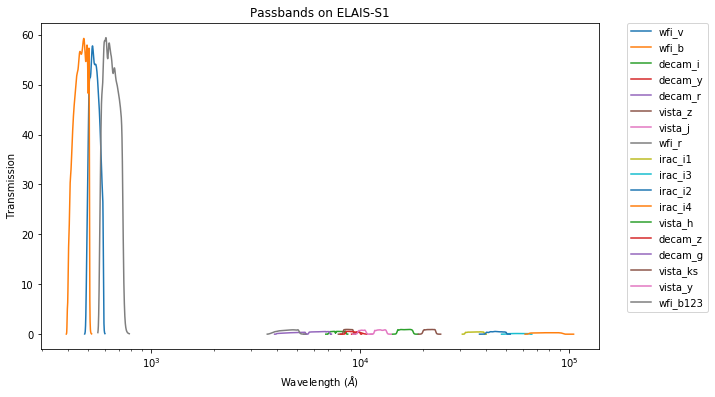

In [15]:
for b in bands:
    plt.plot(Table(data = parse_single_table(FILTERS_DIR + b + '.xml').array.data)['Wavelength']
            ,Table(data = parse_single_table(FILTERS_DIR + b + '.xml').array.data)['Transmission']
            , label=b)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Transmission')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Passbands on {}'.format(FIELD))

### IV.a - Depth overview
Then we plot the mean depths available across the area a given band is available

In [16]:
average_depths = []
for b in ap_bands:
    
    mean_err = np.nanmean(depths['ferr_ap_{}_mean'.format(b)])
    print("{}: mean flux error: {}, 3sigma in AB mag (Aperture): {}".format(b, mean_err, flux_to_mag(3.0*mean_err*1.e-6)[0]))
    average_depths += [('ap_' + b, flux_to_mag(1.0*mean_err*1.e-6)[0], 
                        flux_to_mag(3.0*mean_err*1.e-6)[0], 
                        flux_to_mag(5.0*mean_err*1.e-6)[0])]
    
for b in tot_bands:
    
    mean_err = np.nanmean(depths['ferr_{}_mean'.format(b)])
    print("{}: mean flux error: {}, 3sigma in AB mag (Total): {}".format(b, mean_err, flux_to_mag(3.0*mean_err*1.e-6)[0]))
    average_depths += [(b, flux_to_mag(1.0*mean_err*1.e-6)[0], 
                        flux_to_mag(3.0*mean_err*1.e-6)[0], 
                        flux_to_mag(5.0*mean_err*1.e-6)[0])]
    
average_depths = np.array(average_depths,  dtype=[('band', "<U16"), ('1s', float), ('3s', float), ('5s', float)])
    

wfi_b: mean flux error: 0.054401807487010956, 3sigma in AB mag (Aperture): 25.868163540031013
wfi_b123: mean flux error: 0.05324237421154976, 3sigma in AB mag (Aperture): 25.891553329403074
wfi_v: mean flux error: 0.10746744275093079, 3sigma in AB mag (Aperture): 25.129004576412946
wfi_r: mean flux error: 0.09391207247972488, 3sigma in AB mag (Aperture): 25.275393301217242
irac_i3: mean flux error: 5.8527259007131, 3sigma in AB mag (Aperture): 20.788801399744038
irac_i4: mean flux error: 5.78632855538187, 3sigma in AB mag (Aperture): 20.801189138634122
decam_g: mean flux error: 0.12168966494844545, 3sigma in AB mag (Aperture): 24.994062624824856
decam_r: mean flux error: 0.15984290092380252, 3sigma in AB mag (Aperture): 24.697963481232442
decam_i: mean flux error: 0.24659686578722279, 3sigma in AB mag (Aperture): 24.227227982024026
decam_z: mean flux error: 0.4820690610782045, 3sigma in AB mag (Aperture): 23.49942371419764
decam_y: mean flux error: 1.1746954519327797, 3sigma in AB mag 

In [17]:
def FWHM(X,Y):
    
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = half_max - Y
    #plot(X,d) #if you are interested
    #find the left and right most indexes
    low_end = X[np.where(d < 0)[0][0]]
    high_end = X[np.where(d < 0)[0][-1]]
    return low_end, high_end, (high_end - low_end)


In [18]:
data = []

for b in ap_bands:
    data += [['ap_' + b, Table(data = parse_single_table(FILTERS_DIR + b +'.xml').array.data)]]
    
for b in tot_bands:
    data += [[b, Table(data = parse_single_table(FILTERS_DIR + b +'.xml').array.data)]]

In [19]:
wav_range = []
for dat in data:
    print(dat[0], FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission'])))
    wav_range += [[dat[0], FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))]]


ap_wfi_b (408.5, 505.5, 97.0)
ap_wfi_b123 (3875.0, 5105.0, 1230.0)
ap_wfi_v (495.0, 583.5, 88.5)
ap_wfi_r (570.5, 729.0, 158.5)
ap_irac_i3 (50246.301, 64096.699, 13850.398)
ap_irac_i4 (64415.199, 92596.797, 28181.598)
ap_decam_g (4180.0, 5470.0, 1290.0)
ap_decam_r (5680.0, 7150.0, 1470.0)
ap_decam_i (7090.0, 8560.0, 1470.0)
ap_decam_z (8490.0, 9960.0, 1470.0)
ap_decam_y (9510.0, 10170.0, 660.0)
ap_irac_i1 (31754.0, 39164.801, 7410.8008)
ap_irac_i2 (39980.102, 50052.301, 10072.199)
ap_vista_y (9740.0, 10660.0, 920.0)
ap_vista_j (11670.0, 13380.0, 1710.0)
ap_vista_h (15000.0, 17900.0, 2900.0)
ap_vista_ks (19930.0, 23010.0, 3080.0)
ap_vista_z (8300.0, 9260.0, 960.0)
wfi_b (408.5, 505.5, 97.0)
wfi_b123 (3875.0, 5105.0, 1230.0)
wfi_v (495.0, 583.5, 88.5)
wfi_r (570.5, 729.0, 158.5)
irac_i3 (50246.301, 64096.699, 13850.398)
irac_i4 (64415.199, 92596.797, 28181.598)
decam_g (4180.0, 5470.0, 1290.0)
decam_r (5680.0, 7150.0, 1470.0)
decam_i (7090.0, 8560.0, 1470.0)
decam_z (8490.0, 9960.0, 1470

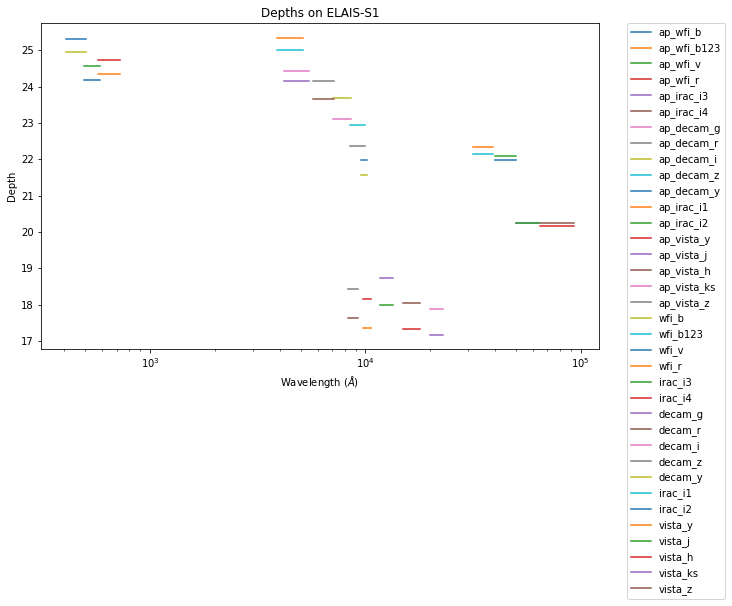

In [20]:
for dat in data:
    wav_deets = FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))
    depth = average_depths['5s'][average_depths['band'] == dat[0]]
    #print(depth)
    plt.plot([wav_deets[0],wav_deets[1]], [depth,depth], label=dat[0])
    
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Depth')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Depths on {}'.format(FIELD))

### IV.c - Depth vs coverage comparison

How best to do this? Colour/intensity plot over area? Percentage coverage vs mean depth?

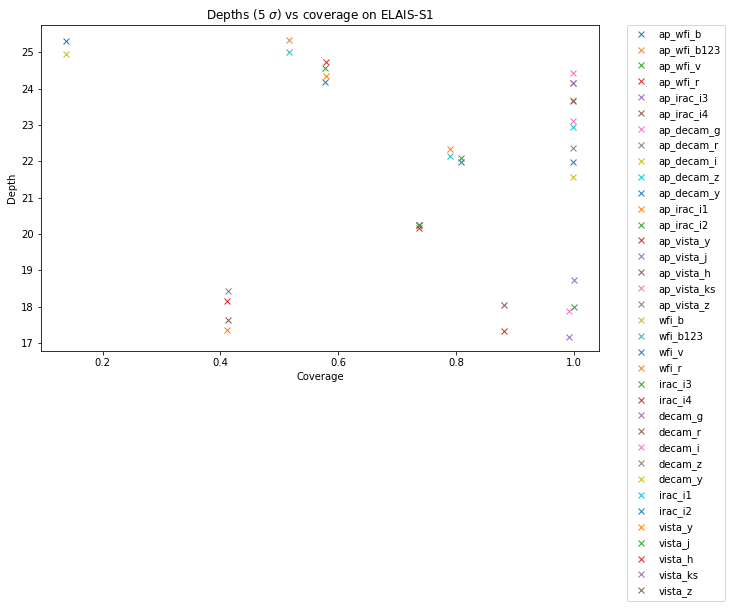

In [21]:
for dat in data:
    wav_deets = FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))
    depth = average_depths['5s'][average_depths['band'] == dat[0]]
    #print(depth)
    coverage = np.sum(~np.isnan(depths['ferr_{}_mean'.format(dat[0])]))/len(depths)
    plt.plot(coverage, depth, 'x', label=dat[0])
    
plt.xlabel('Coverage')
plt.ylabel('Depth')
#plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Depths (5 $\sigma$) vs coverage on {}'.format(FIELD))